# TEST

In [3]:
from libraries import * # Import libraries from libraries.py
from import_data import * # Import data from import_data.py
from global_variables import * # Import global variables from global_variables.py
from plotting_functions import * # Import plotting functions from plotting_functions.py

df_joined_cases = pd.read_csv(os.getcwd().split('API-201Z')[0] + 'API-201Z/Data Sources/cleaned_joined_states.csv')


testing testing one two three

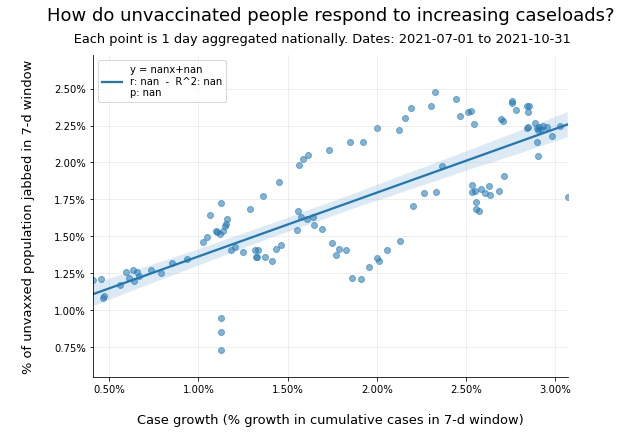

In [4]:
agg_lm(
    data=df_joined_cases,
    groupby=None,
    hue_levels={"Total":'gray'},    
    suptitle='Each point is 1 day aggregated nationally'
)


In [5]:
import pandas as pd
from sklearn import datasets
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data)
df.columns = ['Age', 'Sex', 'BMI', 'ABP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
df['target'] = diabetes.target

est = sm.OLS(endog=df['target'], exog=sm.add_constant(df[df.columns[0:4]])).fit()
est2 = sm.OLS(endog=df['target'], exog=sm.add_constant(df[df.columns[0:6]])).fit()

stargazer = Stargazer([est, est2])

HTML(stargazer.render_html())